In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
warnings.simplefilter('ignore')


In [2]:
df=pd.read_csv('weatherAUS.csv')
df = df.dropna(subset = ['RainTomorrow'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142193 entries, 0 to 145458
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [555]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    The class provides basic functionality for retrieving
    a subset of columns from the dataset.
    """
    
    def __init__(self, feature_names):
        """
        Initialize class instance by setting
        a list of columns to retrieve from the dataset.
        """
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        """
        Fit FeatureSelector to X, but really do nothing.
        Return self.
        """
        return self
    
    def transform(self, X, y=None):
        """
        Transform X using feature selection. 
        Return column-subset of X.
        """
        return X[self.feature_names]

In [556]:
class DateTransformer(BaseEstimator, TransformerMixin):
    """
    The class provides transformation on features to make them cyclic
    """
    
    def __init__(self, type, drop=True):
        """
        Initialize class instance
        
        Parameters
        ----------
        type: str, 
            unit of time to perform to cyclic.
            options:
            - 'M' -- months;
            - 'D' -- days.
        drop: bool, 
            if True (default), remove the original columns from the dataset.
        """
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
        self.drop = drop
        self.type = type
    
    def fit(self, X, y=None):
        """
        Fit DateTransformer to X, but really do nothing.
        Return self.
        """
        return self
    
    def transform(self, X, y=None):
        """
        Transform X. 
        Transform date columns to cyclic using sin and cos functions.
        """
        columns = X.columns
        for col in columns:
            X[col] = pd.to_datetime(X[col])
            if self.type == "D":
                new_col_name = self.type+"_sin"
                X[col] = X[col].dt.day
                X[new_col_name] = np.sin(2 * np.pi * X[col]/31)
                new_col_name = self.type+"_cos"
                X[new_col_name] = np.cos(2 * np.pi * X[col]/31)
            if self.type == "M":
                new_col_name = self.type+"_sin"
                X[col] = X[col].dt.month
                X[new_col_name] = np.sin(2 * np.pi * X[col]/12)
                new_col_name = self.type+"_cos"
                X[new_col_name] = np.cos(2 * np.pi * X[col]/12)
        if self.drop:
            X.drop(columns, axis=1, inplace=True)
        return X


In [557]:
def get_point(point):
    """
    The function provides to get side of the world
    by geographical point of Australia.

    Parameters
        ----------
        point: str, 
            geographical point.
    """
    if point in ["Darwin", "AliceSprings", "Richmond", "Katherine", "Uluru"]:
        return "N"
    elif point in ["Albany", "PerthAirport", "Witchcliffe",
                 "PearceRAAF"]:
        return "W"
    elif point in ["Perth", "Hobart", "Adelaide", "Bendigo",
                "MountGambier", "Launceston", "Ballarat",
                "Mildura", "Nuriootpa", "Watsonia", "Portland",
                "Woomera", "SalmonGums", "Dartmoor", "Moree",
                "Walpole", "Melbourne", "Nhil"]:
        return "S"
    else:
        return "E"

In [558]:
class LocationTransformer(BaseEstimator, TransformerMixin):
    """
    The class provides transform column with geographical objects
    via replace point to side of the world.
    """
    
    def __init__(self):
        """
        Initialize class.
        """
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
        
    def fit(self, X, y=None):
        """
        Fit FeatureSelector to X, but really do nothing.
        Return self.
        """
        return self
    
    def transform(self, X, y=None):
        """
        Transform X by calling for each row in the column function get_point.
        """
        columns = X.columns
        for col in columns:
            X[col]=X[col].apply(get_point)
        return X

In [559]:
class InterpolateInputer(BaseEstimator, TransformerMixin):
    """
    The class provides impute missing values by column interpolation.
    """
    
    def __init__(self, method):
        """
        Initialize class instance.

        Parameters
        ----------
        method: str, 
            method of interpolation.
        options:
            - 'linear',
            - 'pad',
            - 'polynominal',
            -  etc...
        """
        BaseEstimator.__init__(self)
        TransformerMixin.__init__(self)
        self.method = method
        
    def fit(self, X, y=None):
        """
        Fit FeatureSelector to X, but really do nothing.
        Return self.
        """
        return self
    
    def transform(self, X, y=None):
        """
        Impute missing values in X via using standart pandas method - interpolate.
        """
        return X.interpolate(method=self.method)

In [560]:
translate_ohe = OneHotEncoder(sparse=False)
translate_ohe_locations = OneHotEncoder(sparse=False)
translate_oe = OrdinalEncoder()
transformer_rb = RobustScaler()

# Date cyclic in nature.
# If I do not do any preprocessing on them and directly feed them to model,
# the model can give me a wrong result. 
# Days will have values from 1 to 31, so model thinks that value 31 is more than 1.
# This is the reason to cycle date in the dataset using DateTransformer.

date_pipeline = Pipeline(
    steps=[
        ('date_selector', FeatureSelector(['Date'])),
        ('day_transformer', DateTransformer('D', drop=False)),
        ('month_transformer', DateTransformer('M')), 
    ]
)

# In the categorical features there are missing values.
# As the missing values are less than 10%, I will impute them with the mode.
# In the categorical features a few unique values,
# it allows me to use OneHotEncoder for a better representation of the data

categorical_pipeline = Pipeline(
    steps=[
        ('categorical_selector', FeatureSelector(['WindGustDir', 'WindDir9am',
                                                'WindDir3pm', 'RainToday'])),
        ('categorical_imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('categorical_translator', translate_ohe)
    ]
)

# In the 'Location' feature there are more then 20 unique values.
# First of all I need to transform location feature
# via replacing city with side of the world,
# then I can use OneHotEncoder

location_pipeline = Pipeline(
    steps=[
        ('location_selector', FeatureSelector(['Location'])),
        ('location_transformer', LocationTransformer()),
        ('location_ohe', translate_ohe_locations)
    ]
)

# In the numerical features there are several columns
# wich corelate with each other:
    # Temp3pm and MaxTemp
    # Pressure3pm and Pressure9am
    # Temp9am and MinTemp
    # Temp9am and MaxTemp
    # Temp3pm and Temp9am
# One feature of each pairs I didnt include to the FeatureSelector.
# The dataframe represented as time series, 
# so I can use Interpolation to inpute missing values.
# For missing values in the head and tail
# of the dataset I used median stratege of the SimpleImputer.
# Then I chose Robust as scaler to reduce the impact of outliers.

numerical_pipeline = Pipeline(
    steps=[
        ('numerical_selector', FeatureSelector(['MinTemp', 'MaxTemp', 'Rainfall',
                                                'Evaporation', 'Sunshine', 'WindGustSpeed',
                                                'WindSpeed9am', 'Humidity3pm', 'Pressure9am', 
                                                'Cloud9am', 'Cloud3pm'])),
        ('interpolate_inputer', InterpolateInputer('linear')),
        ('categorical_imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scaler', transformer_rb),
    ]
)

In [561]:
full_pipeline = FeatureUnion(transformer_list=[
    ('date', date_pipeline),
    ('location', location_pipeline),
    ('category', categorical_pipeline),
    ('num', numerical_pipeline)
])

In [562]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, df.columns != 'RainTomorrow'],
                                                    translate_oe.fit_transform(df[['RainTomorrow']]))

In [563]:
def get_model(method, params, preparation):
    """
    Function builds pipeline of full data preparation and launches grid search
    with parameters passed in `params` and return the best model.
    
    Parameters
    ----------
    method: <class 'type'>,
        class for binary classification.
    params: dict,
        params for GridSearch.
    preparation: pipeline, transformer,
        preparation step for pipeline.
    """
    
    pip = Pipeline(
        steps=[
            ('preparation', preparation), 
            ('gc', GridSearchCV(method(random_state=29), params, n_jobs=-1,
                                scoring='roc_auc', cv=5, refit=True, verbose=2)
            )
        ]
    )

    pip.fit(X_train, y_train)
    y_true, y_pred = y_test, pip.predict(X_test)
    
    print(metrics.classification_report(y_true, y_pred))
    print('Best params found:\n', pip['gc'].best_params_)
    return pip

In [564]:
pd.DataFrame(full_pipeline.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,0.5,0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.019417,0.00,1.126984,-1.00,0.000000,0.583333,0.275862,-0.489130,0.6,0.60
1,0.5,0.866025,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.873786,0.00,1.650794,-1.15,1.000000,1.083333,-0.586207,-0.054348,-0.8,0.56
2,0.5,0.866025,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.669903,3.50,-0.968254,-1.30,-1.176471,-0.500000,1.344828,1.717391,-0.5,0.52
3,0.5,0.866025,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.446602,3.00,-0.825397,-0.43,-0.352941,0.333333,-0.137931,0.815217,-0.2,0.48
4,0.5,0.866025,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.116505,0.00,-0.682540,0.44,-0.470588,-0.500000,-0.862069,0.510870,0.1,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106639,0.5,0.866025,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.893204,1.75,1.317460,0.52,-0.235294,0.750000,0.482759,-0.489130,0.0,-0.60
106640,0.5,0.866025,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.864078,5.50,1.126984,0.04,-0.882353,0.166667,-0.068966,-0.326087,-0.8,-0.80
106641,0.5,0.866025,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.310680,12.25,0.936508,-0.44,1.647059,2.166667,-0.310345,-1.130435,0.4,-0.80
106642,0.5,0.866025,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.368932,0.00,0.936508,-0.44,-1.000000,-0.333333,0.758621,0.445652,0.4,-0.80


Fitting 5 folds for each of 14 candidates, totalling 70 fits
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     27512
         1.0       0.72      0.47      0.57      8037

    accuracy                           0.84     35549
   macro avg       0.79      0.71      0.74     35549
weighted avg       0.83      0.84      0.83     35549

Best params found:
 {'C': 0.1, 'penalty': 'l2'}


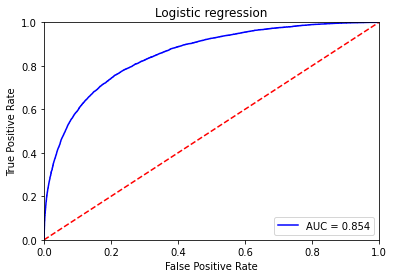

In [565]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1", "l2"]}
m=get_model(LogisticRegression, grid, full_pipeline)

y_score_lr = m.decision_function(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('Logistic regression')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.3f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     27512
         1.0       0.71      0.46      0.56      8037

    accuracy                           0.83     35549
   macro avg       0.78      0.70      0.73     35549
weighted avg       0.82      0.83      0.82     35549

Best params found:
 {'max_depth': 10}


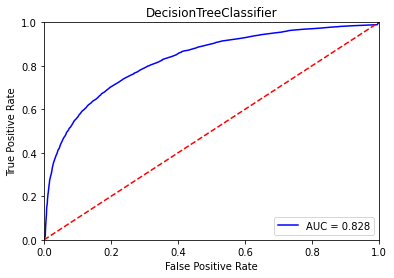

In [566]:
grid={"max_depth": [2,5,10,15,20,50]}
m=get_model(tree.DecisionTreeClassifier, grid, full_pipeline)

y_score_lr = m.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr[:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('DecisionTreeClassifier')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.3f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Fitting 5 folds for each of 4 candidates, totalling 20 fits
              precision    recall  f1-score   support

         0.0       0.86      0.96      0.91     27512
         1.0       0.77      0.47      0.58      8037

    accuracy                           0.85     35549
   macro avg       0.81      0.71      0.74     35549
weighted avg       0.84      0.85      0.83     35549

Best params found:
 {'max_depth': 30, 'n_estimators': 110}


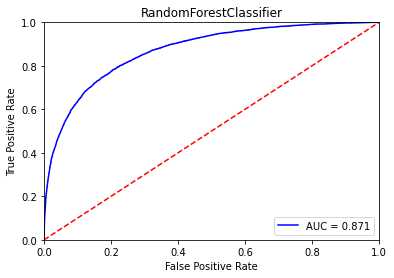

In [569]:
grid={"max_depth": [10,20,30, 40], "n_estimators": [20, 40, 60, 80, 110]}
m=get_model(RandomForestClassifier, grid, full_pipeline)

y_score_lr = m.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr[:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.title('RandomForestClassifier')
plt.plot(fpr_lr, tpr_lr, 'b', label = 'AUC = %0.3f' % roc_auc_lr)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()